In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
df = pd.read_csv('drive/MyDrive/S05-hw-dataset.csv')

Размер датасета: (3000, 17)
Первые строки:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057        

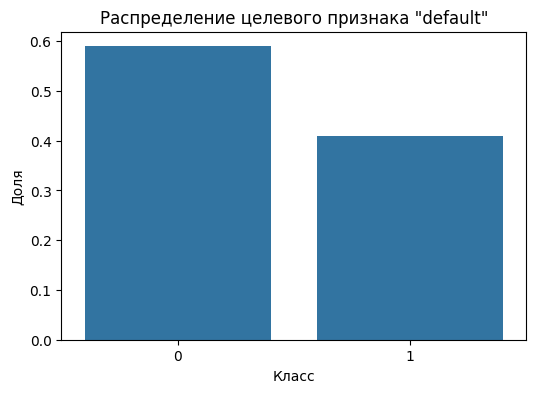

Объектов: 3000, признаков: 17
Пропусков: 0
Дефолт: 0.4103333333333333, Не дефолт: 0.5896666666666667


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

print("Размер датасета:", df.shape)

print("Первые строки:")
print(df.head())

print("Информация о столбцах:")
print(df.info())

print("Описательные статистики:")
print(df.describe())

print("Распределение целевого признака 'default':")
target_dist = df['default'].value_counts(normalize=True)
print(target_dist)

plt.figure(figsize=(6,4))
sns.barplot(x=target_dist.index, y=target_dist.values)
plt.title('Распределение целевого признака "default"')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.show()

print(f"Объектов: {df.shape[0]}, признаков: {df.shape[1]}")
print(f"Пропусков: {df.isnull().sum().sum()}")
print(f"Дефолт: {target_dist[1]}, Не дефолт: {target_dist[0]}")

In [9]:
y = df['default']
X = df.drop(columns=['client_id', 'default'])

print("Типы признаков:")
print(X.dtypes)
print()

if X['debt_to_income'].between(0, 1).all():
  print('корректный диапазон debt_to_income')
else:
  print('некорректный диапазон debt_to_income')
print()

print("Пропуски в признаках:")
print(X.isnull().sum())
print()

print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")

Типы признаков:
age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object

корректный диапазон debt_to_income

Пропуски в признаках:
age                               0
income                            0
years_employed                    0
credit_score                      0
debt_to_income                    0
num_credit_cards                  0
num_late_payments                 0
has_mortgage                 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"Обучающая выборка: {X_train.shape[0]}")
print(f"Тестовая выборка: {X_test.shape[0]}")
print()

baseline = DummyClassifier(strategy="most_frequent", random_state=42)
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)
y_pred_proba = baseline.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

Обучающая выборка: 2250
Тестовая выборка: 750

Accuracy: 0.589
ROC-AUC: 0.500


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

Лучший параметр 1.0

Accuracy: 0.793
ROC-AUC: 0.865



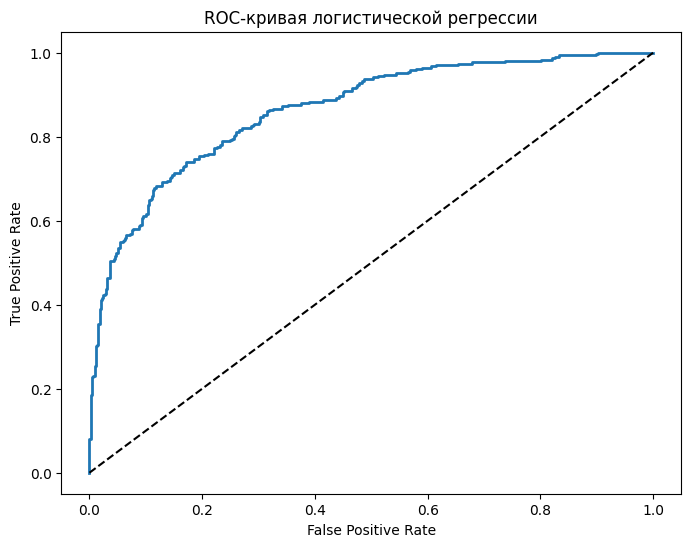

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Лучший параметр", grid_search.best_params_['logreg__C'])
print()

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LogReg (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая логистической регрессии')
plt.savefig('figure1.png', dpi=300, bbox_inches='tight')
plt.show()
from google.colab import files
files.download('figure1.png')

In [22]:
results = pd.DataFrame({
    'Model': ['DummyClassifier', 'LogisticRegression'],
    'Accuracy': [
        accuracy_score(y_test, DummyClassifier(strategy='most_frequent').fit(X_train, y_train).predict(X_test)),
        accuracy_score(y_test, best_model.predict(X_test))
    ],
    'ROC-AUC': [
        0.500,
        roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    ]
})

print(results.to_string(index=False))

             Model  Accuracy  ROC-AUC
   DummyClassifier  0.589333 0.500000
LogisticRegression  0.793333 0.864709


Текстовый отчет:

Сравнение моделей по качеству:

Бейзлайн модель (DummyClassifier) показывает accuracy 58.9%, что соответствует доле большинства класса (не дефолт - 59%). Его ROC-AUC равен 0.5, что означает отсутствие дискриминационной способности - модель не лучше случайного угадывания.

Логистическая регрессия значительно превосходит бейзлайн: accuracy выросла на 20.4% (с 58.9% до 79.3%), а ROC-AUC увеличился с 0.5 до 0.865, что свидетельствует о хорошей разделяющей способности модели.

Влияние регуляризации:

В ходе GridSearchCV наилучший параметр C оказался равным 1.0. Значения C=0.01 и C=0.1 соответствуют более сильной регуляризации и, вероятно, приводят к недообучению, в то время как C=10.0 может вызвать переобучение. Выбранное значение C=1.0 обеспечивает оптимальный баланс между смещением и дисперсией модели.

Выводы и рекомендации:

Логистическая регрессия демонстрирует существенное улучшение качества предсказаний по сравнению с наивной моделью, что подтверждает наличие полезных паттернов в данных для предсказания дефолта.

ROC-AUC=0.865 указывает на хорошую дискриминационную способность модели, что важно для задачи бинарной классификации с дисбалансом классов (41% дефолтов против 59%).

Для реального применения в скоринге кредитных заявок логистическая регрессия представляется разумным выбором благодаря своей интерпретируемости, устойчивости и полученному качеству предсказаний. Однако для дальнейшего улучшения можно рассмотреть более сложные модели (например, случайный лес или градиентный бустинг) и дополнительные методы обработки дисбаланса классов.